In [12]:
import numpy as np
import matplotlib.pyplot as plt

import skimage as skm

from PIL import Image

import torch

from kedro.extras.datasets.pickle import PickleDataSet

In [16]:
import os, sys
sys.path.append(os.path.abspath('../src'))

from tagseg.pipelines.data_processing.nodes import prepare_input
from tagseg.data.acdc_dataset import AcdcDataSet
from tagseg.data.utils import SimulateTags

In [4]:
dataset = PickleDataSet(filepath='../data/03_primary/acdc_train.pt').load()

In [5]:
transformation_params = dict(perform=True, generator_model='../data/06_models/netG_A2B.pth', batch_size=16)

tagged = prepare_input(dataset, transformation_params)

100%|██████████| 115/115 [00:18<00:00,  6.35it/s]


In [25]:
examples, labels = dataset.tensors
t_examples, t_labels = tagged.tensors

In [17]:
tagger = SimulateTags(
    label=dataset[0][1],
    myo_index=1
)

In [18]:
def tag(image: torch.tensor) -> torch.tensor:
    return tagger(((image - image.min()) / (image.max() - image.min())) * 255)

/opt/conda/envs/tagseg/lib/python3.8/site-packages/matplotlib/backends/backend_pdf.py:1721: DeprecationWarning: NONE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img = img.convert(mode='P', dither=Image.NONE,
/opt/conda/envs/tagseg/lib/python3.8/site-packages/matplotlib/backends/backend_pdf.py:1722: DeprecationWarning: ADAPTIVE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Palette.ADAPTIVE instead.
  palette=Image.ADAPTIVE, colors=num_colors)


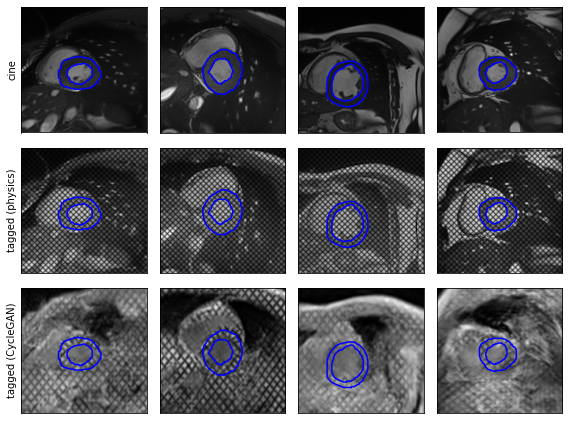

In [27]:
fig, ax = plt.subplots(3, 4, figsize=(8, 6))

names = ['cine', 'tagged (physics)', 'tagged (CycleGAN)']

for n, i in enumerate([12, 171, 1076, 75]):
    
    contours = skm.measure.find_contours(labels[i].numpy())

    ax[0, n].imshow(examples[i, 0], cmap='gray')
    ax[1, n].imshow(tag(examples[i, 0]), cmap='gray')
    ax[2, n].imshow(t_examples[i, 0], cmap='gray')

    for row, name in enumerate(names):
        ax[row, n].get_xaxis().set_ticks([])
        ax[row, n].get_yaxis().set_ticks([])
        ax[row, 0].set_ylabel(name)

        for contour in contours:
            ax[row, n].plot(*contour[:, ::-1].T, c='b')

    cx, cy = contours[1].mean(axis=0)
    padding = 80

    for x in ax:
        x[n].set_xlim(cx - padding, cx + padding)
        x[n].set_ylim(cy + padding, cy - padding)

plt.tight_layout()
plt.savefig('../../figures/cine2tag.pdf', dpi=300, bbox_inches='tight')
plt.show()